# Before You Start

The current set of notebooks are under constant development.

## Update Tutorial Repository

If you have previously cloned the tutorial repository, you may need to get the latest versions of the notebooks.

First check the status of your repository:
```
cd hls4ml-tutorial
git status 
```

You may have some _modified_ notebooks. For example:

```
# On branch csee-e6868-spring2021
# Changes not staged for commit:
#   (use "git add <file>..." to update what will be committed)
#   (use "git checkout -- <file>..." to discard changes in working directory)
#
#	modified:   part1_getting_started.ipynb
#	modified:   part2_advanced_config.ipynb
#	modified:   part2b_advanced_config.ipynb
#
no changes added to commit (use "git add" and/or "git commit -a")
```

You can make a copy of those modified notebooks if you had significat changes, otherwise the easiest thing to do is to discard those changes.

**ATTENTION** You will loose your local changes!

```
git checkout *.ipynb
```

At this point, you can update you copy of the repository:
```
git pull
```


## Update Conda Environment

It is likely that you are running this notebook in the Conda environment `hls4ml-tutorial-cu`.

If you did not do that yet, you should update the `hls4ml` packages with the latest changes in the working branch.

```
conda activate hls4ml-tutorial-cu
pip uninstall hls4ml
pip install git+https://github.com/GiuseppeDiGuglielmo/hls4ml.git@gdg/cosmetics#egg=hls4ml[profiling]
```

You may need to restart the Jupyter notebook.


# Part 3: Compression

The terms _sparsity_, _pruning_, and _compression_ of a neural network are correlated and synonyms in this notebook. For more details look at this blog posts [[1]](https://numenta.com/blog/2019/08/30/case-for-sparsity-in-neural-networks-part-1-pruning) and [[2]](https://numenta.com/blog/2020/10/30/case-for-sparsity-in-neural-networks-part-2-dynamic-sparsity).

A sparse neural network is network where many of the weights are `0` and pruning is a compression technique to reduce the size of the neural network by _introducing more 0s_.

<img src="images/pruning.png" style="width:640px;" />



## Setup

As we did in the previous notebooks, let's import the libraries, call the magic functions, and setup the environment variables.

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


## Fetch the jet tagging dataset from Open ML

The [jet tagging dataset](https://www.openml.org/d/42468) is publicly available on [OpenML](https://www.openml.org).

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Now construct a model

We'll use the same architecture as in the previous notebooks: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation. Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [4]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

Let's visualize the model.

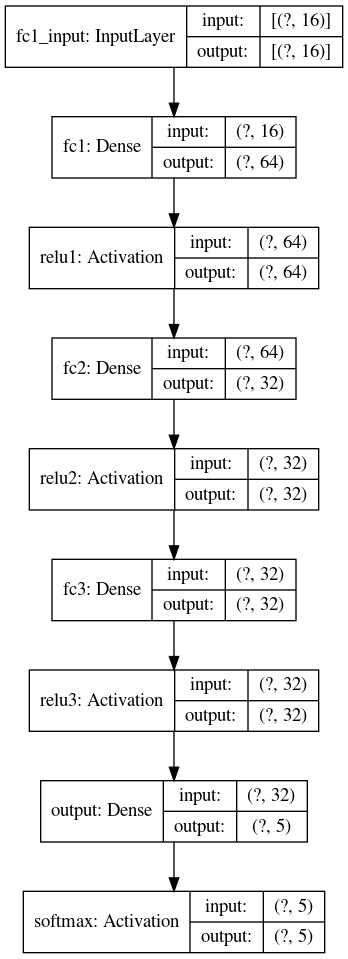

In [5]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Why do we need to compress a model?

Either you are running the model in software, as an FPGA firmware, or implemented as ASIC, a **smaller** model that retains the accuracy is always better. In some cases, you may be also willing to trade-off in accuracy for a smaller footprint, as we already have seen with _post-training quantization_.

<img src="images/before_compression.png" style="width:640px;" />

There is a lot in terms of papers and tools on the topic of pruning. For TensorFlow, you can have a look at this more  [comprehensive_guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide).

<img src="images/after_compression.png" style="width:800px;" />

## Train sparse

This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%.

In particular we use the [prune_low_magnitude](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/prune_low_magnitude) function. This function wraps a `tf.keras` model or layer with pruning functionality which sparsifies the layer's weights during training. For example, using this with 75% sparsity will ensure that 75% of the layer's weights are zero.

Among the parameters for the `prune_low_magnitude` function, we specify `PruningSchedule` object to control the pruning rate throughout training.
- In our case, we are using `ConstantSparsity`, which means that we are using constant sparsity (%) throughout training.
- You can also use `PolynomialDecay` based sparsity, in tha case more or fewer sparsity can be used with increasing or decreasing speed, as training progresses.

In [6]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [7]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_2')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    model.save('model_2/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_2/KERAS_check_best_model.h5')

Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.6388 - accuracy: 0.3027WARNING:tensorflow:From /home/giuseppe/miniconda3/envs/hls4ml-tutorial-cu/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
485/487 [============================>.] - ETA: 0s - loss: 1.3297 - accuracy: 0.5158
***callbacks***
saving losses to model_2/losses.log

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_2/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_2/KERAS_check_model_last.h5

Epoch 00001: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 7ms/step - loss: 1.3290 - accurac

Epoch 13/30
481/487 [============================>.] - ETA: 0s - loss: 0.8220 - accuracy: 0.7264
***callbacks***
saving losses to model_2/losses.log

Epoch 00013: val_loss improved from 0.82952 to 0.82222, saving model to model_2/KERAS_check_best_model.h5

Epoch 00013: val_loss improved from 0.82952 to 0.82222, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00013: saving model to model_2/KERAS_check_model_last.h5

Epoch 00013: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 5ms/step - loss: 0.8220 - accuracy: 0.7263 - val_loss: 0.8222 - val_accuracy: 0.7271
Epoch 14/30
477/487 [============================>.] - ETA: 0s - loss: 0.8149 - accuracy: 0.7283
***callbacks***
saving losses to model_2/losses.log

Epoch 00014: val_loss improved from 0.82222 to 0.81563, saving model to model_2/KERAS_check_best_model.h5

Epoch 00014: val_loss improved from 0.82222 to 0.81563, saving model to model_2/KER

Epoch 26/30
482/487 [============================>.] - ETA: 0s - loss: 0.7655 - accuracy: 0.7418
***callbacks***
saving losses to model_2/losses.log

Epoch 00026: val_loss improved from 0.77154 to 0.76908, saving model to model_2/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 0.77154 to 0.76908, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00026: saving model to model_2/KERAS_check_model_last.h5

Epoch 00026: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 5ms/step - loss: 0.7657 - accuracy: 0.7417 - val_loss: 0.7691 - val_accuracy: 0.7413
Epoch 27/30
484/487 [============================>.] - ETA: 0s - loss: 0.7634 - accuracy: 0.7426
***callbacks***
saving losses to model_2/losses.log

Epoch 00027: val_loss improved from 0.76908 to 0.76695, saving model to model_2/KERAS_check_best_model.h5

Epoch 00027: val_loss improved from 0.76908 to 0.76695, saving model to model_2/KER

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.75


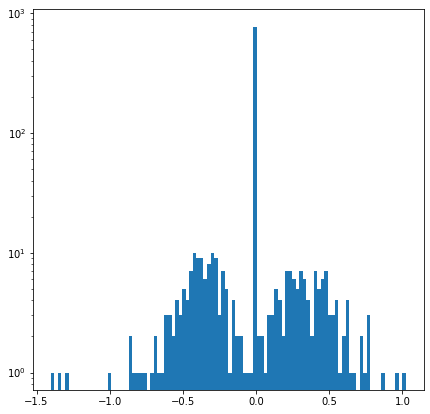

In [8]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check performance

How does this 75% sparse model compare against the unpruned model?

Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from [Part 1](part1_getting_started.ipynb) is shown with dashed lines.

**Make sure you've trained the model from Part 1**

-----------------------------------
Unpruned Accuracy: 0.7503072289156627
Pruned   Accuracy: 0.7426867469879518
-----------------------------------


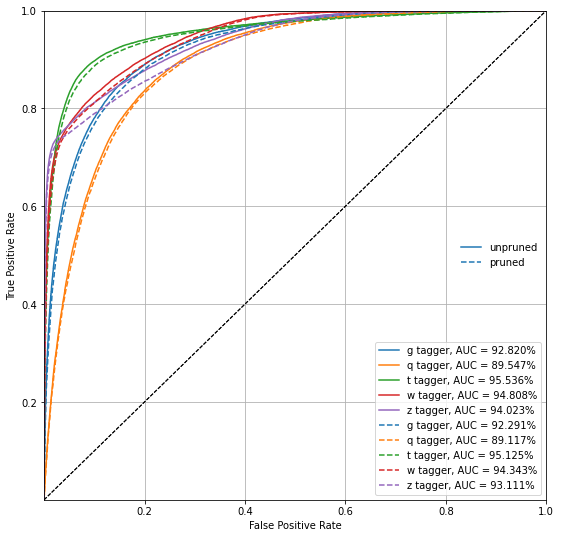

In [9]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
model_ref = load_model('model_1/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)

print('-----------------------------------')
print("Unpruned Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Pruned   Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))
print('-----------------------------------')

# Enable logarithmic scale on TPR and FPR axes 
logscale_tpr = False # Y axis
logscale_fpr = False # X axis

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.plotMultiClassRoc(y_test, y_ref, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_prune, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['unpruned', 'pruned'],
            loc='center right', frameon=False)
_ = ax.add_artist(leg)

# Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the [Part 1](part1_getting_started.ipynb) model.

We need to use the function [strip_pruning](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/strip_pruning) to change the layer types back to their originals: once a model has been pruned to required sparsity, this method can be used to restore the original model with the sparse weights.

**This takes approx. 10 minutes on Columbia servers.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vivado_hls.log`

In [10]:
%%time 
import hls4ml

# Save the model again but with the pruning 'stripped' to use the regular layer types
model = strip_pruning(model)

# Use the default configuration for hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_2/hls4ml_prj',
                                                       #fpga_part='xczu7ev-ffvc1156-2-e') # ZCU106
                                                       fpga_part='xczu3eg-sbva484-1-e') # Ultra96
                                                       #fpga_part='xc7z020clg400-1') # Pynq-Z1
                                                       #fpga_part='xc7z007sclg225-1') # MiniZed
hls_model.compile()

hls_results = hls_model.build(csim=False)

# print('-----------------------------------')
# #print(hls_results) # Print hashmap
# print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
# print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
# print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
# print("BRAM_18K:               {} (Aval. {})".format(hls_results['BRAM_18K'], hls_results['AvailableBRAM_18K']))
# print("DSP48E:                 {} (Aval. {})".format(hls_results['DSP48E'], hls_results['AvailableDSP48E']))
# print("FF:                     {} (Aval. {})".format(hls_results['FF'], hls_results['AvailableFF']))
# print("LUT:                    {} (Aval. {})".format(hls_results['LUT'], hls_results['AvailableLUT']))
# print("URAM:                   {} (Aval. {})".format(hls_results['URAM'], hls_results['AvailableURAM']))
# print('-----------------------------------')

CPU times: user 6.65 s, sys: 175 ms, total: 6.83 s
Wall time: 8min 24s


## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [11]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj/')

Found 1 solution(s) in model_2/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Feb 24 17:13:14 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.332 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+------

**ATTENTION: you need to have trained and synthesized the model from Part 1**

Print the report for the model trained in [Part 1](part1_getting_started.ipynb).

- Remember these two models have the same architecture, but the model in this notebook was trained using the sparsity API from TensorFlow Model Optimization.
- Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vivado HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. 

In [12]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Feb 24 16:46:21 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.198 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+-------

Finally, remember how we are learning how to reduce the hardware-resource usage without affecting (too much) the model accuracy.

<img src="images/boards.png" style="width:640pt;" />